# Multi-armed bandit problem

### Задание
**1. Можно ли вычислить $Q_{t+1}(a)$ инкрементально (известно лишь  $Q_t(a)$ и награда  $r_{t+1}$, назначенная за выбор действия $a$)?**

Пусть $Q_t(a) = \frac{\sum_k r_{k}}{c_t(a)}$. При выборе на $t+1$-ом шаге действия $a:\; Q_{t+1}(a) =  \frac{\sum_k r_{k} \; + \; r_{t+1}}{c_t(a) + 1} = \frac{Q_{t}(a) \cdot c_t(a) \; + \; r_{t+1}}{c_t(a) + 1}$

### Построим для начала нашу модель:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [2]:
class MAB_Model:
    def __init__(self, actions):
        self.actions = actions
        self.reward_means = np.random.normal(size=actions)
    def get_reward(self, action):
        return np.random.normal(self.reward_means[action])
    
class MAB_Strategy:
    def __init__(self, model):
        self.model = model
        self.reward_means = np.zeros((model.actions))
        self.action_uses = np.zeros((model.actions))
    def make_step(self): # Maybe should return reward
        pass
    def update_reward(self, action, reward):
        self.reward_means[action] = (self.reward_means[action] * self.action_uses[action] + reward)\
        / (self.action_uses[action] + 1)
        self.action_uses[action] += 1
    def best_actions(self):
        best =  np.argwhere(self.reward_means == np.max(self.reward_means))
        return best.reshape(best.shape[0])
    
class Player:
    def __init__(self, actions, steps, strategy_class, **kwargs):
        self.actions = actions
        self.strategy_class = strategy_class
        self.steps = steps
        self.strategy_args = kwargs
    def evaluate(self, games=10000, progressbar=True, hold=False, show=True, show_opt=False, color='b', label=' '):
        rewards = np.zeros(self.steps)
        optimum = 0.0
        if progressbar:
            games_range = log_progress(range(games), every=10)
        else:
            games_range = range(games)
        for game in games_range:
            model = MAB_Model(self.actions)
            optimum += model.reward_means.max()
            strategy = self.strategy_class(model, **(self.strategy_args))
            for i in range(self.steps):
                rewards[i] += strategy.make_step()
        rewards /= games
        optimum /= games
        if show:
            x = np.arange(1, self.steps+1)
            plt.plot(x, rewards, color, label=label)
            plt.title('Average reward', fontsize=16)
            if not hold:
                plt.show()
        return rewards

### Реализуем жадную стратегию

In [3]:
class Greedy(MAB_Strategy):
    def __init__(self, model):
        MAB_Strategy.__init__(self, model)
    def make_step(self):
        best = self.best_actions()
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

In [ ]:
player = Player(100, 1000, Greedy)
result = player.evaluate(games=10000)
print('Total reward:', result.sum())

Её основной недостаток достаточно очевиден: сначала действия выбираются абсолютно случайно, и если на первом шаге алгоритм выберет "плохой" автомат, но на котором случайно выпал хороший выигрыш, он так и продолжит на нём играть, и переключится на другие автоматы только тогда, когда средний выигрыш на автомате станет неположительным. Кроме того, если выигрыш будет положителен, но мал, алгоритм так и продолжит использовать этот автомат, даже если есть более выгодные автоматы.

В качестве начальной стратегии использовался просто случайный выбор автомата.

Конечно же, из указанных выше соображений было бы неплохо провести начальную серию игр для того, чтобы собранная информация в большей степени соответствовала реальному матожиданию выигрыша на каждом автомате. Кроме того, очевидно, что у автомата с большим матожиданием выигрыша вероятность выпадения высокого слычайного выигрыша больше, чем у автомата с меньшим матожиданием выигрыша, поэтому выбор автомата с наибольшим выигрышем вместо случайного автомата в среднем должно улучшать результат

Для наглядности запустим аналогичную симуляцию, но в которой для каждого запуска алгоритм предварительно дважды дёргал за ручку каждого автомата:

In [ ]:
class InitializingPlayer:
    def __init__(self, actions, steps, strategy_class, **kwargs):
        self.actions = actions
        self.strategy_class = strategy_class
        self.steps = steps
        self.strategy_args = kwargs
    def evaluate(self, games=10000):
        rewards = np.zeros(self.steps)
        for game in log_progress(range(games), every=1):
            model = MAB_Model(self.actions)
            strategy = self.strategy_class(model, **(self.strategy_args))
            for action in range(model.actions):
                reward = strategy.model.get_reward(action)
                strategy.update_reward(action, reward)
                rewards[action] += reward
            for action in range(model.actions):
                reward = strategy.model.get_reward(action)
                strategy.update_reward(action, reward)
                rewards[model.actions + action] += reward
            for i in range(self.steps - 2 * model.actions):
                rewards[2 * model.actions + i] += strategy.make_step()
        rewards /= games
        x = np.arange(1, self.steps+1)
        plt.plot(x, rewards, 'b')
        plt.title('Average reward')
        plt.show()
        return rewards.sum()

player = InitializingPlayer(100, 1000, Greedy)
result = player.evaluate(games=10000)
print('Total reward:', result.sum())

### $\varepsilon$ -greedy стратегия

In [4]:
class E_Greedy(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
    def make_step(self):
        best = (self.reward_means == np.max(self.reward_means))
        proba = (1-self.eps) * best / best.sum()
        proba += self.eps * np.ones((self.model.actions)) / self.model.actions
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

### Softmax

In [5]:
class Softmax(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
    def make_step(self):
        proba = np.exp( (self.reward_means - np.max(self.reward_means)) / self.eps)
        proba = proba / proba.sum()
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

### Upper Confidence Bound

In [6]:
class UCB(MAB_Strategy):
    def __init__(self, model, eps):
        MAB_Strategy.__init__(self, model)
        self.eps = eps
        self.step = 0
    def make_step(self):
        value = self.reward_means.copy()
        value += self.eps * np.sqrt(2 * math.log(self.step + 1) / (self.action_uses + 0.001))
        self.step += 1
        best =  np.argwhere(value == np.max(value))
        best = best.reshape(best.shape[0])
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


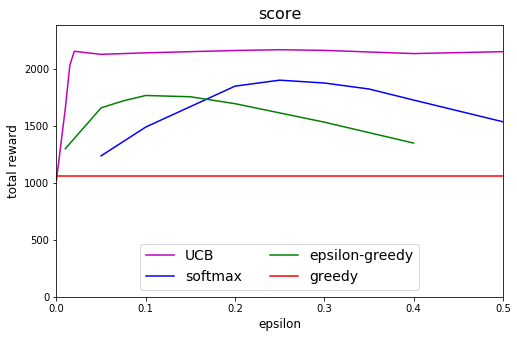

In [8]:

# ATTENTION: takes a significant amount of time to be processed
games_num = 2000

player = Player(100, 1000, Greedy)
result = player.evaluate(games=games_num, show=False)
greedy_sum = result.sum()

egreedy_epsilons = [0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4]
egreedy_results = []
for e in log_progress(egreedy_epsilons, every=1):
    player = Player(100, 1000, E_Greedy, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False)
    egreedy_results.append(res.sum())
    
softmax_epsilons = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
softmax_results = []
for e in log_progress(softmax_epsilons, every=1):
    player = Player(100, 1000, Softmax, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False)
    softmax_results.append(res.sum())
    
ucb_epsilons = [0, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
ucb_results = []
for e in log_progress(ucb_epsilons, every=1):
    player = Player(100, 1000, UCB, eps=e)
    res = player.evaluate(games=games_num, show=False, progressbar=False)
    ucb_results.append(res.sum())

plt.figure(figsize=(8, 5))
plt.title('score', fontsize=16)
plt.axis([0, max(egreedy_epsilons[-1], softmax_epsilons[-1], ucb_epsilons[-1]),
          0, max(*egreedy_results, *softmax_results, *ucb_results)*1.1])
plt.xlabel('epsilon', fontsize=12)
plt.ylabel('total reward', fontsize=12)
plt.hold(True)
plt.plot(ucb_epsilons, ucb_results, 'm', label='UCB', linewidth=1.5)
plt.plot(softmax_epsilons, softmax_results, 'b', label='softmax', linewidth=1.5)
plt.plot(egreedy_epsilons, egreedy_results, 'g', label='epsilon-greedy', linewidth=1.5)
plt.plot([0, max(softmax_epsilons[-1], egreedy_epsilons[-1])], [greedy_sum, greedy_sum],
         'r', label='greedy', linewidth=1.5)
plt.hold(False)
plt.legend(loc='lower center', fontsize=14, ncol=2)
plt.show()

Таким образом, мы определили наилучшие коэффициенты $\varepsilon$ для алгоритмов -  $\varepsilon=0.1$ для $\varepsilon-greedy$, $\varepsilon=0.25$ для $softmax$ и $\varepsilon=0.25$ для $UCB$ и проверили превосходство UCB над прочими алгоритмами. Кроме того, заметно, что $UCB$ гораздо менее чувствителен к изменению параметров

Посмотрим теперь в динамике, как растёт средняя награда в процессе игры при запуске наилучших версий алгоритмов:

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


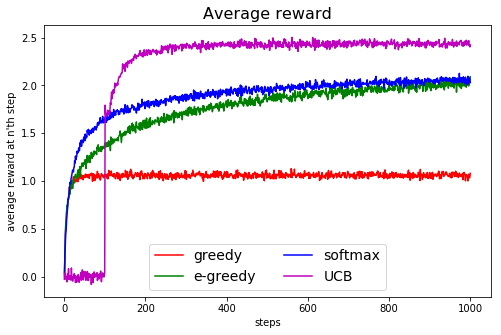

In [9]:
games_num = 2000

plt.figure(figsize=(8, 5))
plt.xlabel('steps')
plt.ylabel("average reward at n'th step")
plt.hold(True)
greedy_player = Player(100, 1000, Greedy)
greedy_player.evaluate(games=games_num, show=True, hold=True, color='r', label='greedy')
e_greedy_player = Player(100, 1000, E_Greedy, eps=0.1)
e_greedy_player.evaluate(games=games_num, show=True, hold=True, color='g', label='e-greedy')
softmax_player = Player(100, 1000, Softmax, eps=0.25)
softmax_player.evaluate(games=games_num, show=True, hold=True, color='b', label='softmax')
ucb_player = Player(100, 1000, UCB, eps=0.25)
ucb_player.evaluate(games=games_num, show=True, hold=True, color='m', label='UCB')
plt.hold(False)
plt.legend(loc='lower center', ncol=2, fontsize=14)
plt.show()

In [ ]:
class Gradient(MAB_Strategy):
    def __init__(self, model, alpha, correct):
        MAB_Strategy.__init__(self, model)
        self.alpha = alpha
        self.correct = correct
        self.priorities = np.zeros((model.actions))
    def update_reward(self, action, reward):
        old_rewards = self.reward_means.copy()
        self.reward_means += self.alpha * (reward - self.reward_means[action])
        mask = np.zeros((self.model.actions))
        mask[action] += 1
        neg_mask = 1 - 2*mask
        self.priorities += self.correct * (reward - old_rewards) * (mask + self.priorities * neg_mask)
    def make_step(self):
        proba = np.exp(self.priorities - np.max(self.priorities))
        proba = proba / proba.sum()
        action = np.random.choice(self.model.actions, p=proba)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward

In [ ]:
player = Player(100, 1000, Gradient, alpha=0.4, correct=0.2)
result = player.evaluate(games=500)
print('Total reward:', result.sum())